# Coral Bleaching
## Exploratory Data Analysis

1. Temperature metrics
2. y-profiling
3. Other weather features
4. Data by year
5. Geographic patterns
6. Further cleaning and saving

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from matplotlib.widgets import Slider
#%matplotlib notebook

import ydata_profiling
from ydata_profiling import ProfileReport

In [2]:
# Import data
file_path = '../data/interim/coral_bleaching_cleaned_v1.csv'

df = pd.read_csv(file_path)
df.shape

(34393, 58)

### 1. Temperature metrics

Unsurprisingly, many of the temperature metrics are correlated with each other. Removing the mean, standard deviation, minimum, and maximum of these  metrics will greatly reduce the number of features we are working with. 

The correlation with each of these metrics and bleaching is less obvious, but there appears to be a positive correlation with both Temperature and TSA with percent bleaching. Frequency and DHW metrics have a large spread at low bleaching levels, possibly due to the sheer number of observations at that bleaching level. However, it should be used with caution if incorporated into a model. 

<AxesSubplot: >

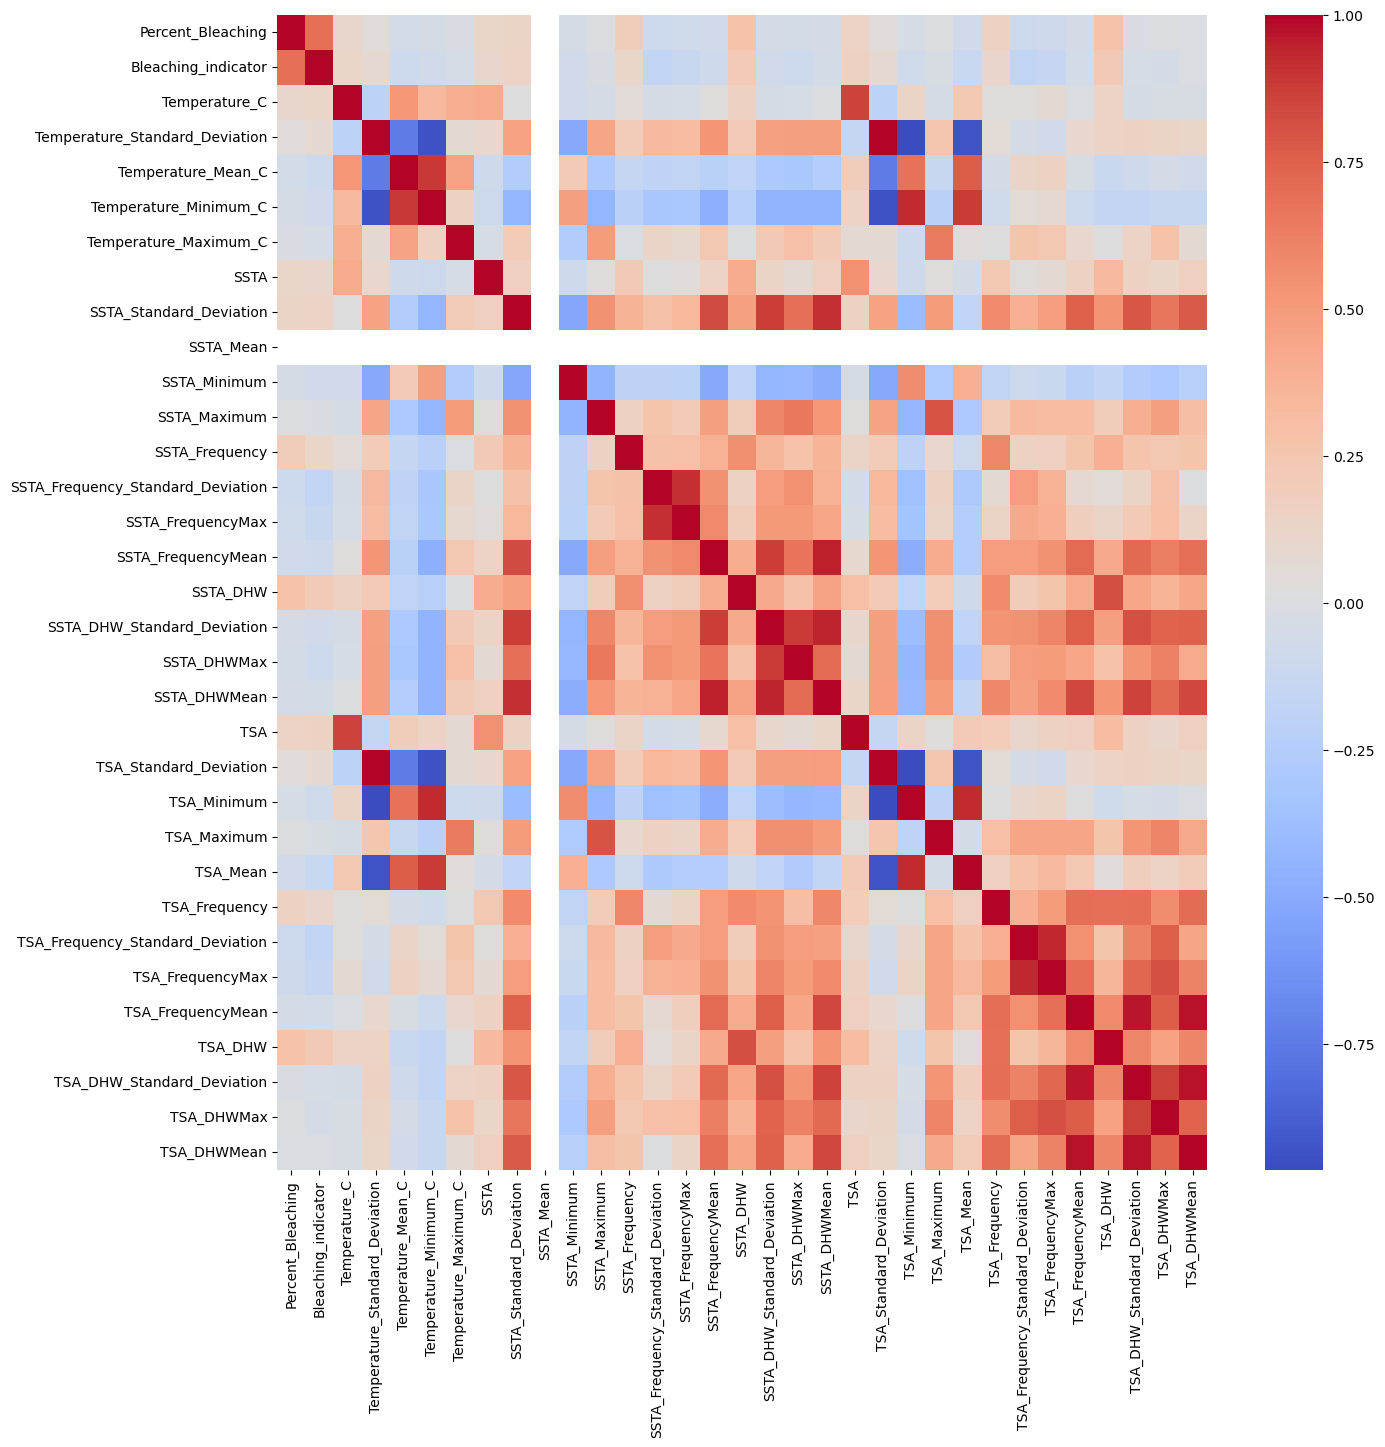

In [3]:
# Correlation between temperature metrics and bleaching
temp = ['Percent_Bleaching', 'Bleaching_indicator', 
        'Temperature_C', 'Temperature_Standard_Deviation', 'Temperature_Mean_C', 'Temperature_Minimum_C', 'Temperature_Maximum_C',
        'SSTA', 'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum', 
        'SSTA_Frequency','SSTA_Frequency_Standard_Deviation', 'SSTA_FrequencyMax', 'SSTA_FrequencyMean',
        'SSTA_DHW','SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 
        'TSA', 'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean', 
        'TSA_Frequency','TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax', 'TSA_FrequencyMean', 
        'TSA_DHW', 'TSA_DHW_Standard_Deviation','TSA_DHWMax', 'TSA_DHWMean']

df_temp = df[temp]

fig = plt.figure(figsize=(15,15))
sns.heatmap(df_temp.corr(), cmap='coolwarm')

In [4]:
# remove temperature columns with high correlation to reduce number of features
temp_remove = ['ClimSST', 'Temperature_Standard_Deviation', 'Temperature_Mean_C', 'Temperature_Minimum_C', 
               'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum', 
               'SSTA_Frequency_Standard_Deviation', 'SSTA_FrequencyMax', 'SSTA_FrequencyMean',
               'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 
               'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean', 
               'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax', 'TSA_FrequencyMean', 
               'TSA_DHW_Standard_Deviation','TSA_DHWMax', 'TSA_DHWMean']

df2 = df.drop(columns=temp_remove)
df2.shape

(34393, 34)

### 2. Ydata-profile

Now that the number of features are reduced by nearly half, it is more manageable to run the y-profiling report. The report is used to identify missing values or anomolies in the data, as well as an overview of correlations. 

- There are a number of names/ID features that are not likely to be useful in modelling including: Site_ID, Sample_ID, Data_Source, Reef_ID, Ecoregion_Name, Country_Name, State_Island_Province_Name, City_Town_Name
- Substrate_Name is only available from one Data_Source and therefore is missing in 35% of the data. This should be dropped due to the large amount of missing data. 
- Ignoring ID and name features identified above, Bleaching_indicator seems to be slightly correlated with Distance_to_Shore. Realm_Name, SSTA_DHW, TSA, TSA_DHW
- Over one third of the data is zero for SSTA_DHW, TSA_Frequency, and TSA_DHW features. I will be cautious if using these features at the modelling stage. 


In [5]:
report = ProfileReport(df2, sort=None, 
                       html={"style": {"full_width": True}})
report.to_file("../reports/y_profile_data.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
/opt/anaconda3/lib/python3.11/site-packages/scipy/st

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 3. Other Weather Features

The boxplots below show nearly all of the features have many outliers. However, there are features with a slightly higher mean and/or interquartile range associated with the presence of bleaching including:  depth, distance to shore, SSTA DHW, SSTA frequency, TSA DHW, TSA frequency, and temperature. Latitude and longitude are more difficult to discern patterns because the boxplots do not capture the complete spatial relationship (i.e. longitude of -180 equals +180 degrees). 

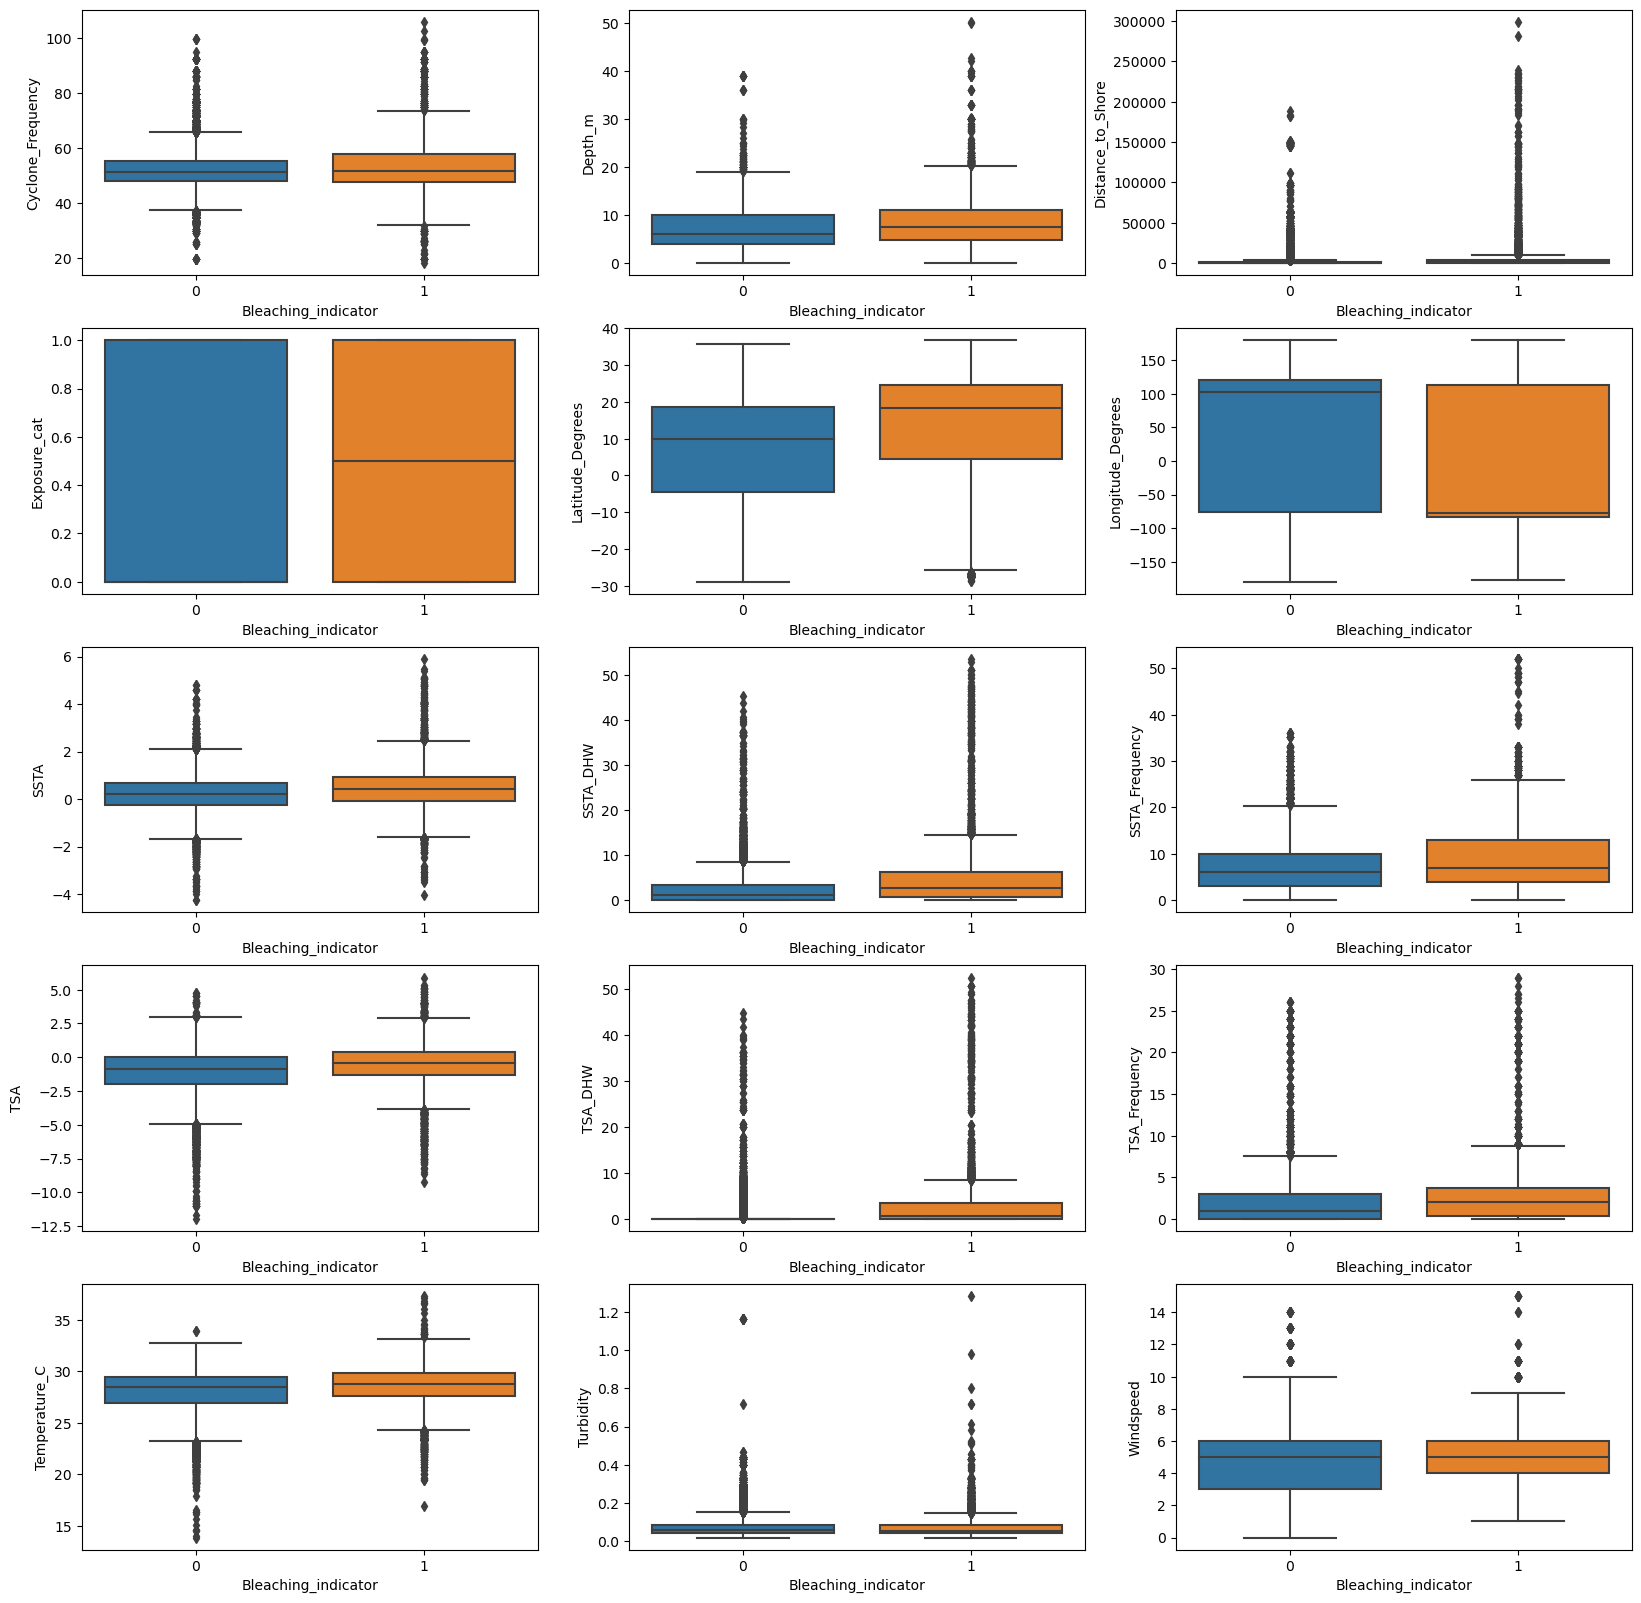

In [5]:
# Patterns with other features and bleaching indicator
features = ['Cyclone_Frequency', 'Depth_m', 'Distance_to_Shore', 'Exposure_cat', 
            'Latitude_Degrees', 'Longitude_Degrees', 'SSTA', 'SSTA_DHW', 'SSTA_Frequency', 
            'TSA', 'TSA_DHW', 'TSA_Frequency', 'Temperature_C', 'Turbidity', 'Windspeed']

fig, axes = plt.subplots(5,3, figsize=(20,20))

for col, ax in zip(features, axes.flat): 
    sns.boxplot(data=df2, x='Bleaching_indicator', y=col, ax=ax)

### 4. Data by Year

There have been three major global bleaching events recorded in 1998, 2010, and 2014-2017. In addition to global events, major bleaching events have been recorded locally in the Caribbean and Australian in 2002 and 2005. The following graphs appear to be consistent with these years, particularly the proportional graph where at least 40% of observations indicated the presence of bleaching (over 5%). 

Text(0, 0.5, 'Number of observations')

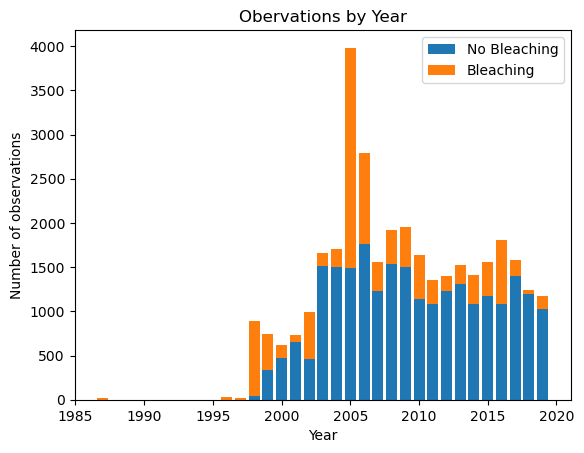

In [6]:
# Visualize number of observations by year
count_by_year = df2.groupby('Date_Year')['Bleaching_indicator'].value_counts().unstack()

plt.bar(count_by_year.index, count_by_year[0], label='No Bleaching')
plt.bar(count_by_year.index, count_by_year[1], bottom=count_by_year[0], label='Bleaching')
plt.legend()
plt.title('Obervations by Year')
plt.xlabel('Year')
plt.ylabel('Number of observations')

Text(0, 0.5, 'Proportion of observations')

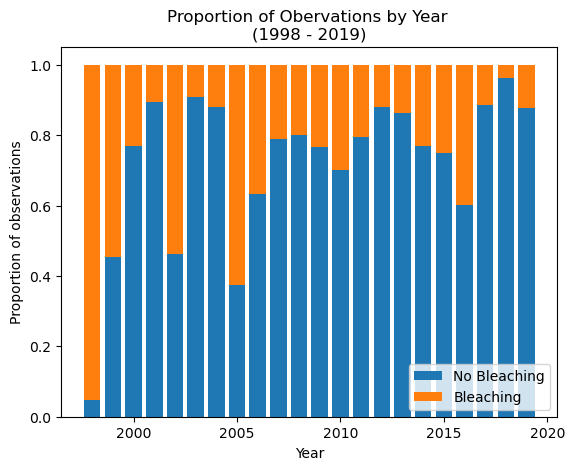

In [7]:
# Visualize proportion of observations by year
count_by_year = df2.groupby('Date_Year')['Bleaching_indicator'].value_counts(normalize=True).unstack()
count_by_year = count_by_year[count_by_year.index >= 1998]


plt.bar(count_by_year.index, count_by_year[0], label='No Bleaching')
plt.bar(count_by_year.index, count_by_year[1], bottom=count_by_year[0], label='Bleaching')
plt.legend()
plt.title('Proportion of Obervations by Year \n(1998 - 2019)')
plt.xlabel('Year')
plt.ylabel('Proportion of observations')

### 5. Geographic Visualizations

If regional features are used in the modelling phase, realm seems to be a reasonable grouping because it has a manageable number of values (unlike by country). Additionally, realm is correlated with latitude and longitude and should capture those features as well. The boxplots by realm show the three Indo-Pacific regions appear to have similar interquartile ranges, and so I may consider combining those regions into one to simplify the number of features.

In [8]:
# From GeoPandas, our world map data
worldmap_path = '../ne_110m_admin_0_countries.shp'
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

/var/folders/32/0gd9yf194_vbqz8wsbsl0ltw0000gn/T/ipykernel_6125/2321238293.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Tropical Atlantic'),
  Text(1, 0, 'Eastern Indo-Pacific'),
  Text(2, 0, 'Western Indo-Pacific'),
  Text(3, 0, 'Central Indo-Pacific'),
  Text(4, 0, 'Temperate Northern Pacific'),
  Text(5, 0, 'Tropical Eastern Pacific'),
  Text(6, 0, 'Temperate Australasia'),
  Text(7, 0, 'Temperate Northern Atlantic')])

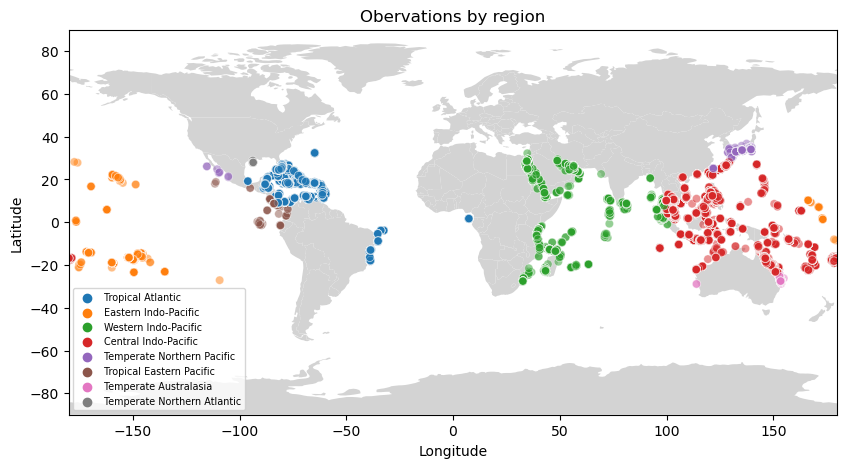

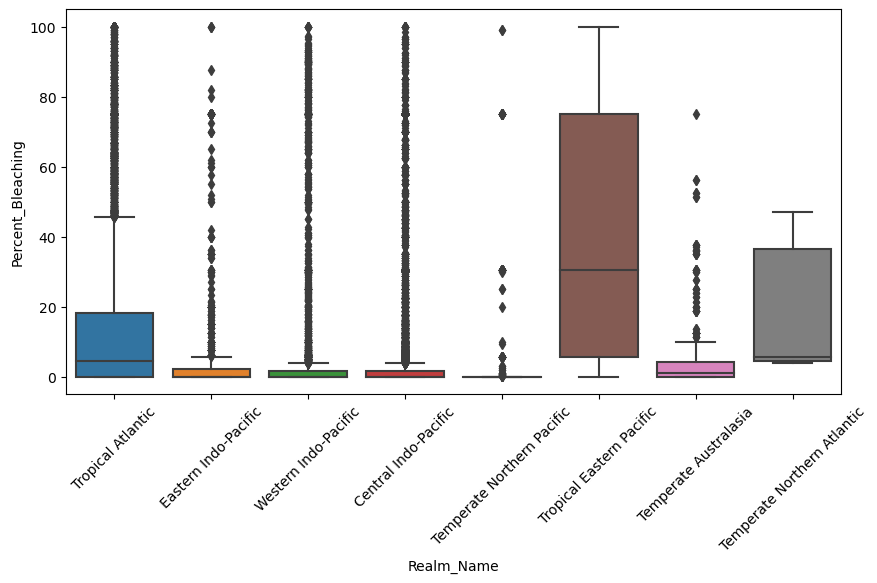

In [9]:
# Map of different regions
fig, ax = plt.subplots(1,1, figsize=(10,5))
worldmap.plot(ax=ax, color='lightgrey')
x = df2['Longitude_Degrees']
y = df2['Latitude_Degrees']
region = df2['Realm_Name']
sns.scatterplot(x=x, y=y, hue=region, alpha=.5)

plt.legend(loc='lower left', fontsize='x-small')

plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("Obervations by region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Boxplots of percent bleaching by region
plt.figure(figsize=(10,5))
sns.boxplot(data=df2, x='Realm_Name', y='Percent_Bleaching')
plt.xticks(rotation=45)

Text(80.34722222222221, 0.5, 'Latitude')

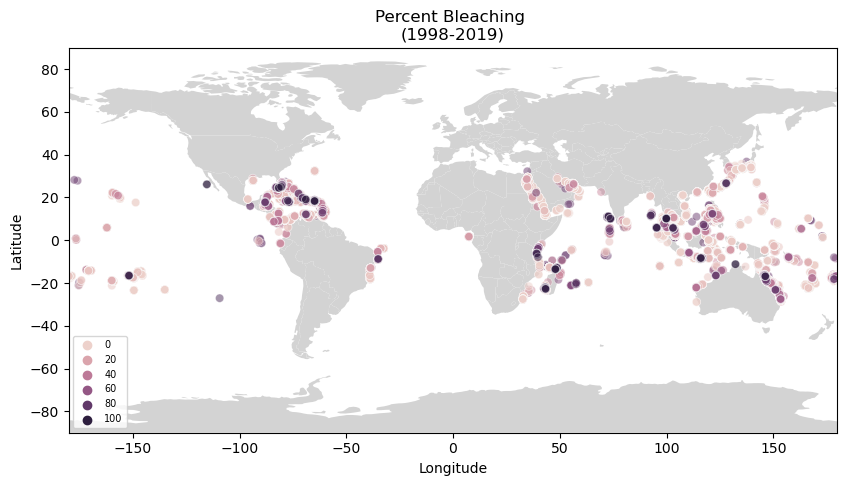

In [10]:
# Map by percent bleaching
fig, ax = plt.subplots(1,1, figsize=(10,5))
worldmap.plot(ax=ax, color='lightgrey')
x = df2['Longitude_Degrees'][df2['Date_Year']>=1998]
y = df2['Latitude_Degrees'][df2['Date_Year']>=1998]
bleach = df2['Percent_Bleaching'][df2['Date_Year']>=1998]
sns.scatterplot(x=x, y=y, hue=bleach, alpha=.5)

plt.legend(loc='lower left', fontsize='x-small')

plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title("Percent Bleaching \n(1998-2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

This second map may indicate that bleaching may be impacted by regional factors, as it looks like there is more concentrated bleaching observations in the Caribbean, Eastern Africa, Southeast Asia, and Eastern Australia. 

<IPython.core.display.Javascript object>


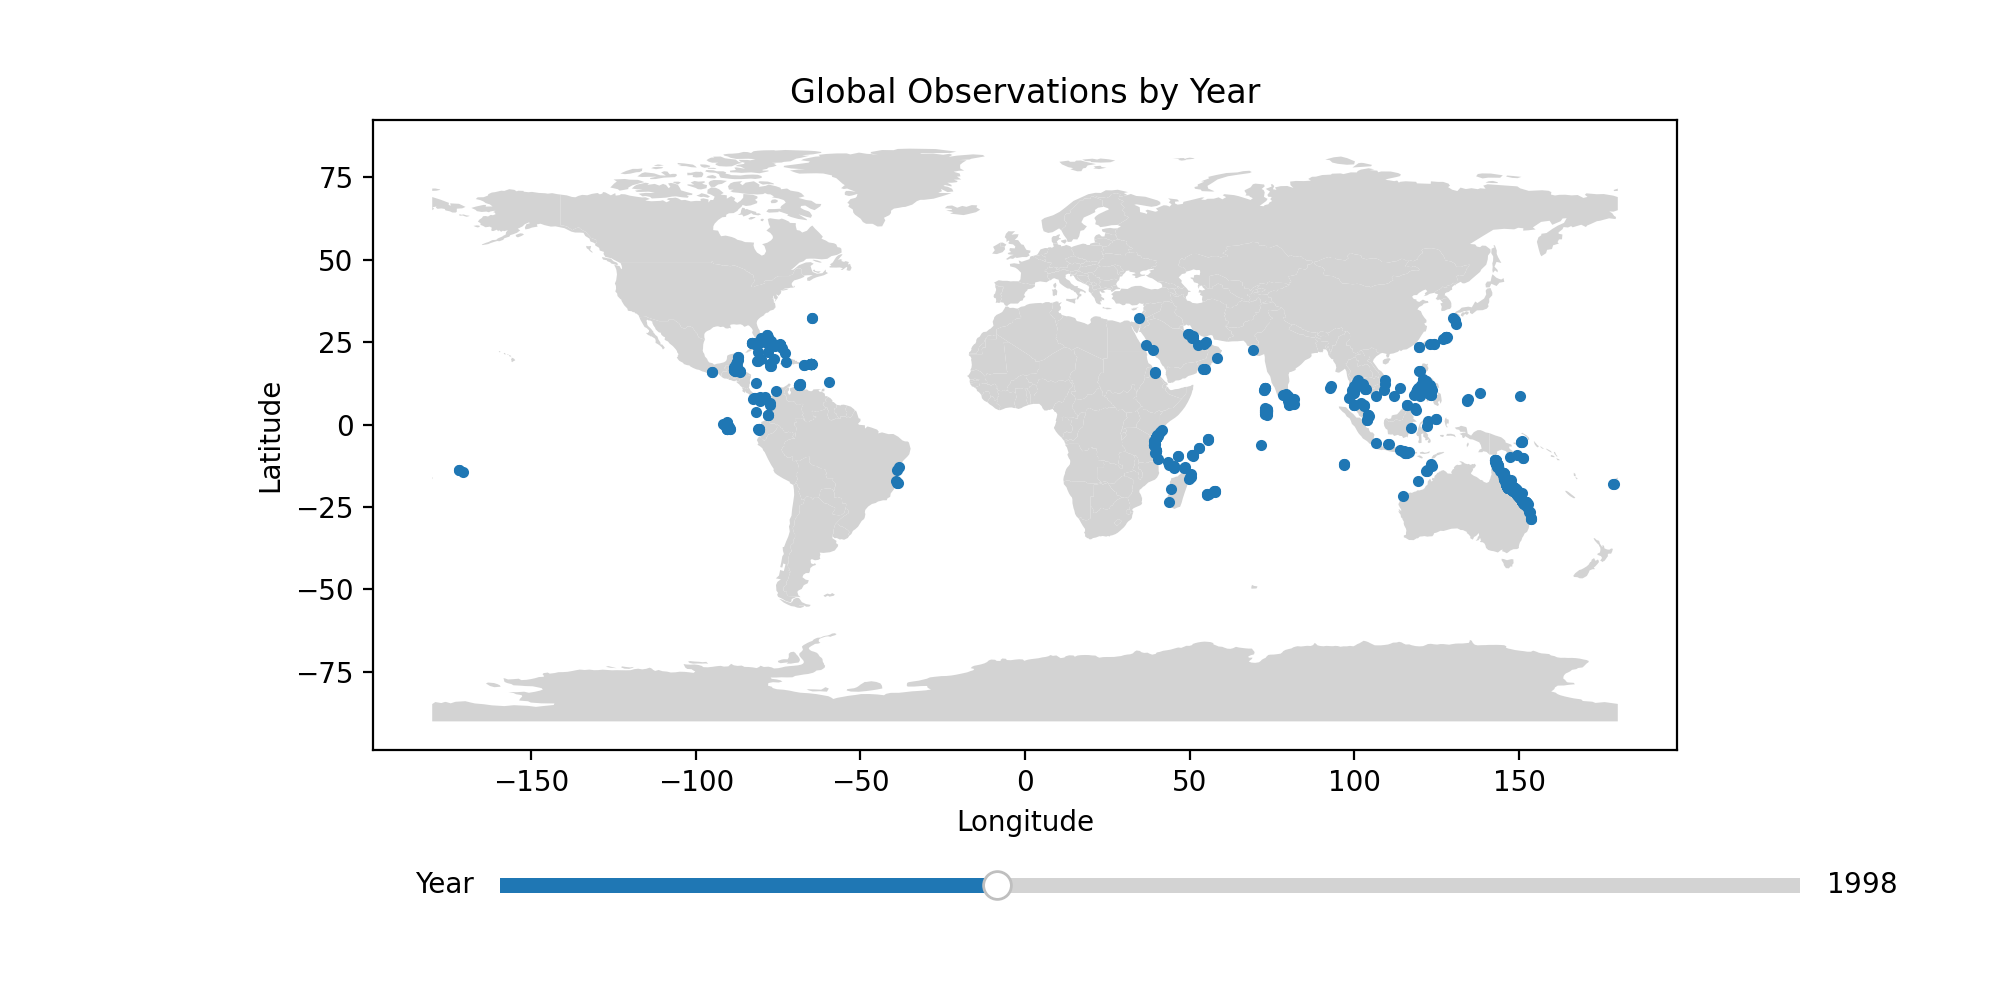

0

In [11]:
%matplotlib notebook

start_year = 1985
end_year = 2019
years = np.linspace(1985, 2019, 35)

# establish plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
worldmap.plot(ax=ax, color='lightgrey')
plt.title("Global Observations by Year")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Set slider
plt.subplots_adjust(bottom=0.25)
sax = plt.axes([0.25, 0.1, 0.65, 0.03])
slide = Slider(sax, 'Year', start_year, end_year, valinit=1998, valstep=years)

# Initial plot
act_data = df2[df2['Date_Year'] == 1998]
s, = ax.plot(act_data['Longitude_Degrees'],act_data['Latitude_Degrees'], 
             ls='', marker='.')

# Update plot with slider value
def update(year):
    act_data = df2[df2['Date_Year'] == float(int(year))]
    X = act_data['Longitude_Degrees']
    Y = act_data['Latitude_Degrees']

    #Update data based on slider
    s.set_xdata(X)
    s.set_ydata(Y)

    fig.canvas.draw()

slide.on_changed(update)


I am caution to use dates or years as a modelling feature because, as seen in this third map, the location of observations from year to year. Despite the year showing high correlation with bleaching in the y-profiling report, there does not seem to be consistency over time with where the data was collected. 

### 6. Further Cleaning and Saving

In [12]:
# dropping other regional columns that will not be used in analysis
drop_columns=['Site_ID', 'Sample_ID', 'Reef_ID', 'Ecoregion_Name', 
              'Exposure', 'City_Town_Name', 'Date_Day', 'Date_Month', 
              'Substrate_Name', 'Data_Source']

# Drop columns and limit years on or after 1998
df3 = df2.drop(columns=drop_columns)[df2['Date_Year']>=1998]
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34251 entries, 0 to 34392
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Latitude_Degrees            34251 non-null  float64
 1   Longitude_Degrees           34251 non-null  float64
 2   Ocean_Name                  34251 non-null  object 
 3   Realm_Name                  34251 non-null  object 
 4   Country_Name                34251 non-null  object 
 5   State_Island_Province_Name  34187 non-null  object 
 6   Distance_to_Shore           34249 non-null  float64
 7   Turbidity                   34251 non-null  float64
 8   Cyclone_Frequency           34251 non-null  float64
 9   Date_Year                   34251 non-null  int64  
 10  Depth_m                     32643 non-null  float64
 11  Percent_Bleaching           34251 non-null  float64
 12  Windspeed                   34251 non-null  float64
 13  SSTA                        342

In [13]:
# save to folder
datapath = '../data/interim/coral_bleaching_cleaned_v2.csv'
df3.to_csv(datapath, index=False)